# Backtesting Analysis

This notebook analyzes the results from rolling-origin backtesting on the validation set.

## Contents
1. Load backtesting results
2. Model performance comparison
3. Metrics by fold
4. Error analysis by horizon
5. Probabilistic forecast evaluation
6. Statistical significance tests

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from src.utils import load_metrics, load_yaml
from src.plots import (
    plot_metrics_by_fold,
    plot_error_by_horizon
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## 1. Load Backtesting Results

In [2]:
# Load all model metrics
models = ['seasonal_naive', 'ets', 'gradient_boosting', 'chronos']

all_metrics = {}
for model in models:
    try:
        metrics = load_metrics(model, '../artifacts/metrics')
        all_metrics[model] = metrics
        print(f"[OK] Loaded {model}")
    except Exception as e:
        print(f"[FAIL] Failed to load {model}: {e}")

[OK] Loaded seasonal_naive
[OK] Loaded ets
[OK] Loaded gradient_boosting
[OK] Loaded chronos


## 2. Model Performance Comparison

In [3]:
# Create metrics comparison table
metrics_df = pd.DataFrame(all_metrics).T

# Select key metrics
key_metrics = ['mae_mean', 'rmse_mean', 'smape_mean', 'mase_mean']
display_df = metrics_df[key_metrics].copy()

# Sort by MASE
display_df = display_df.sort_values('mase_mean')

print("\n=== Validation Performance (Mean across folds) ===")
print(display_df.to_string())
print("\nBest model (by MASE):", display_df.index[0])


=== Validation Performance (Mean across folds) ===
                      mae_mean    rmse_mean smape_mean mase_mean
gradient_boosting   873.302574  1150.267467  14.261244  0.344356
chronos             998.658558  1375.449296  16.675759  0.393786
seasonal_naive     1006.833333  1347.716475   16.56989  0.397009
ets                1288.417838  1662.259418  22.985764  0.508042

Best model (by MASE): gradient_boosting


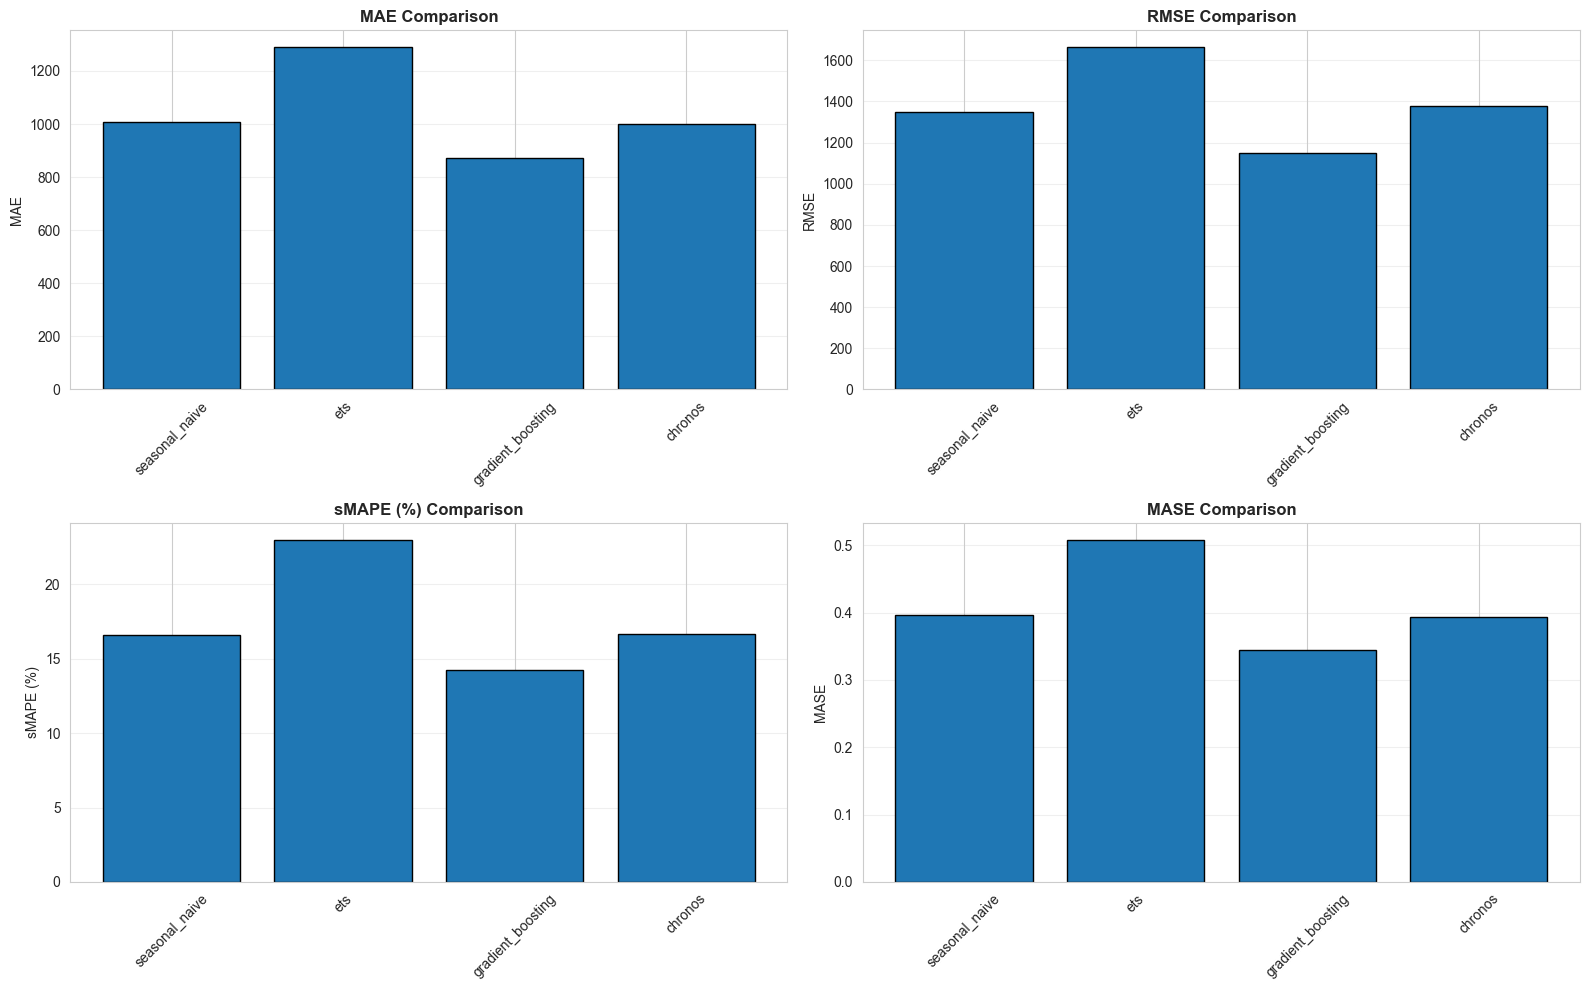

In [4]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metric_names = ['mae_mean', 'rmse_mean', 'smape_mean', 'mase_mean']
titles = ['MAE', 'RMSE', 'sMAPE (%)', 'MASE']

for idx, (metric, title) in enumerate(zip(metric_names, titles)):
    ax = axes[idx // 2, idx % 2]
    
    values = [all_metrics[model][metric] for model in models if metric in all_metrics[model]]
    model_names = [model for model in models if metric in all_metrics[model]]
    
    ax.bar(model_names, values, edgecolor='black')
    ax.set_title(f'{title} Comparison', fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Load Fold-Level Results

In [5]:
# Load backtesting predictions
backtest_dfs = {}

for model in models:
    try:
        df = pd.read_parquet(f'../artifacts/predictions/{model}_backtest.parquet')
        backtest_dfs[model] = df
        print(f"[OK] Loaded {model} predictions: {len(df)} records")
    except Exception as e:
        print(f"[FAIL] Failed to load {model}: {e}")

[OK] Loaded seasonal_naive predictions: 150 records
[OK] Loaded ets predictions: 150 records
[OK] Loaded gradient_boosting predictions: 150 records
[OK] Loaded chronos predictions: 150 records


## 4. Error Analysis by Horizon

C:\Users\Hoang Nhan\AppData\Local\Temp\ipykernel_8712\547125930.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horizon_errors = df.groupby('horizon').apply(
C:\Users\Hoang Nhan\AppData\Local\Temp\ipykernel_8712\547125930.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horizon_errors = df.groupby('horizon').apply(
C:\Users\Hoang Nhan\AppData\Local\Temp\ipykernel_8712\547125930.py:5: FutureWarning: DataFrameGr

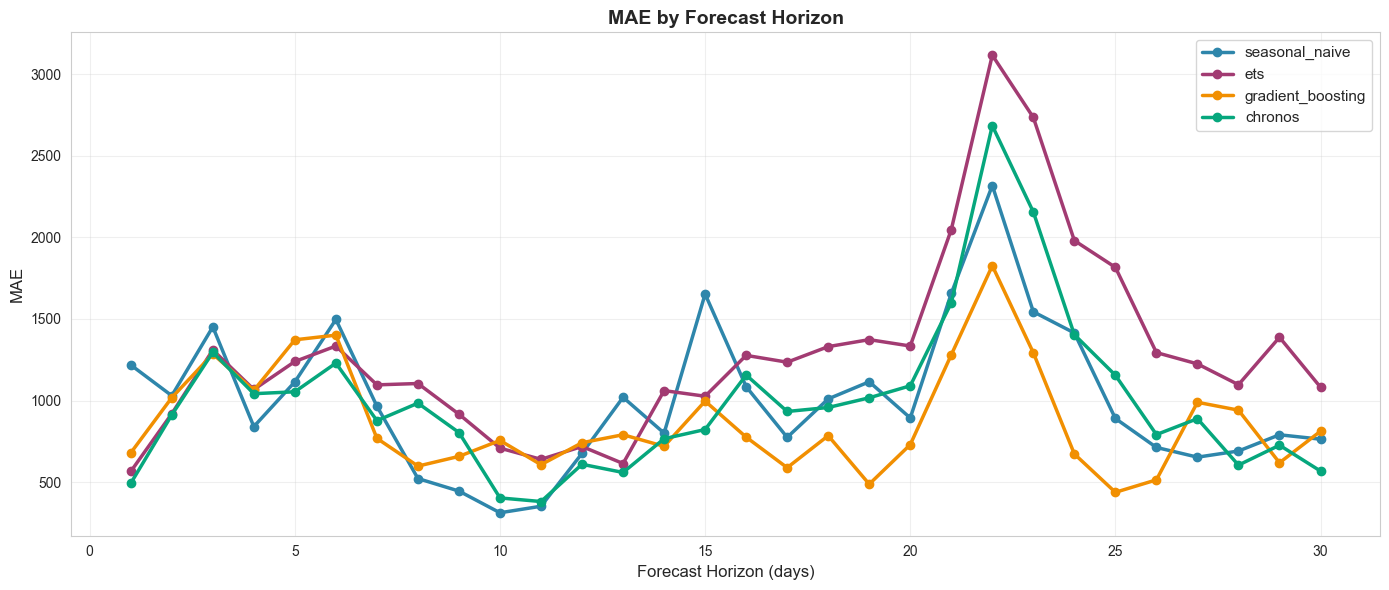

In [6]:
# Compute MAE by horizon for each model
error_by_horizon = {}

for model, df in backtest_dfs.items():
    horizon_errors = df.groupby('horizon').apply(
        lambda x: np.mean(np.abs(x['y_true'] - x['y_pred']))
    ).to_dict()
    error_by_horizon[model] = horizon_errors

# Plot
plot_error_by_horizon(error_by_horizon, metric_name='MAE')

## 5. Statistical Significance Tests

In [7]:
# Load statistical test results
try:
    stats_df = pd.read_csv('../artifacts/metrics/statistical_tests.csv')
    print("\n=== Statistical Significance Tests ===")
    print(stats_df.to_string(index=False))
except Exception as e:
    print(f"Statistical tests not available: {e}")


=== Statistical Significance Tests ===
         model          baseline                      test  statistic  p_value  significant  mean_error_model  mean_error_baseline                                                               interpretation
seasonal_naive gradient_boosting Wilcoxon Signed-Rank Test     4527.0 0.033132         True       1006.833333           873.302574 gradient_boosting significantly outperforms seasonal_naive (p=0.0331 < 0.05)
           ets gradient_boosting Wilcoxon Signed-Rank Test     3093.0 0.000001         True       1288.417838           873.302574            gradient_boosting significantly outperforms ets (p=0.0000 < 0.05)
       chronos gradient_boosting Wilcoxon Signed-Rank Test     4601.5 0.046515         True        998.658558           873.302574        gradient_boosting significantly outperforms chronos (p=0.0465 < 0.05)


## 6. Probabilistic Forecast Evaluation (Chronos)

In [8]:
# Check if quantile predictions are available
if 'chronos' in backtest_dfs:
    chronos_df = backtest_dfs['chronos']
    
    # Check for quantile columns
    quantile_cols = [col for col in chronos_df.columns if col.startswith('q_')]
    
    if quantile_cols:
        print(f"\nQuantile predictions available: {quantile_cols}")
        
        # Compute coverage
        if 'q_0.1' in chronos_df.columns and 'q_0.9' in chronos_df.columns:
            coverage_80 = np.mean(
                (chronos_df['y_true'] >= chronos_df['q_0.1']) & 
                (chronos_df['y_true'] <= chronos_df['q_0.9'])
            )
            print(f"\n80% Prediction Interval Coverage: {coverage_80*100:.2f}%")
            print(f"  Expected: 80%")
            print(f"  {'Well-calibrated!' if abs(coverage_80 - 0.8) < 0.05 else 'Needs calibration'}")
    else:
        print("\nNo quantile predictions found in backtest results")
else:
    print("\nChronos results not available")


Quantile predictions available: ['q_0.1', 'q_0.5', 'q_0.9']

80% Prediction Interval Coverage: 42.67%
  Expected: 80%
  Needs calibration


## Summary

Key findings from backtesting:
1. Best performing model (by MASE)
2. Error increases with forecast horizon
3. Statistical significance of model differences
4. Calibration quality of probabilistic forecasts